In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
import copy
import qutip.floquet as floq
import qutip

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tanh as tanh
import utils.expectation_values as expv
import utils.graph as graph
import utils.saver as saver
from tqdm import tqdm as tqdm

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

In [2]:
amplitude = 3.5 * 2 * np.pi
ramp_slope = 0.5
cut_factor = 3

guess_offset = 0.13168831168831152
guess_duration = 80

In [3]:
# Find a good pulse to start with
offset_range_width = 1
tlist = np.linspace(0, guess_duration, int(guess_duration*5))
guess_fids = []
guess_offset_range = np.linspace(guess_offset-offset_range_width, guess_offset+offset_range_width)
for offset in tqdm(guess_offset_range):
    tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    guess_fids.append(fidelity)

100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


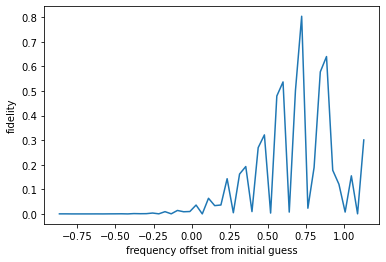

In [4]:
plt.plot(guess_offset_range, guess_fids)
plt.xlabel("frequency offset from initial guess")
plt.ylabel("fidelity")
plt.show()
guess_offset = guess_offset_range[np.argmax(guess_fids)]

In [5]:
# Find a good pulse to start with
def cost(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude, ramp_coeff]
    amplitude = constants[0]
    ramp_slope = constants[1]
    cut_factor = constants[2]
    tlist = np.linspace(0, duration, int(duration*5))
    tanh.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_slope=ramp_slope, cut_factor=cut_factor, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tanh.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    print(fidelity, offset, duration)
    return (1-fidelity)

result1 = sp.optimize.minimize(cost, [guess_offset, guess_duration], [amplitude, ramp_slope, cut_factor], method="Nelder-Mead", options={"disp":True})

t_max = result1.x[1]
offset = result1.x[0]
freq = system.first_energy_spacing/3 - offset
durations = np.arange(0, t_max, (2*np.pi)/(freq*20))

0.8039247756960545 0.7235250463821888 80.0
0.3440555371495555 0.7597012987012983 80.0
0.864710141681125 0.7235250463821888 84.0
0.4698920517660843 0.6873487940630794 84.0
0.22129898593926814 0.7054369202226342 83.0
0.02312752613372521 0.7235250463821888 82.0
0.6711432403646186 0.7416131725417436 82.0
0.15675499258540398 0.7416131725417435 84.0
0.10479237701398403 0.7370911410018548 83.5
0.07315757824329004 0.7325691094619662 83.0
0.3359523255180628 0.7235250463821888 83.0
0.2881857229377121 0.7144809833024115 84.0
0.8245422796953491 0.7190030148423002 83.75
0.16891341670408067 0.7190030148423002 84.75
0.7281455373538279 0.7223945384972167 83.4375
0.5869947762889917 0.7201335227272724 84.3125
0.8479144568292712 0.7218292845547306 83.65625
0.7134486883617318 0.7263513160946192 83.90625
0.8659888447179888 0.72084009015538 83.7890625
0.843612060713699 0.7225358519828381 84.1328125
0.8625555843939466 0.7220059264117575 83.775390625
0.8624239916696087 0.7223592101258112 84.013671875
0.865594

fidelity 0.874978994511216


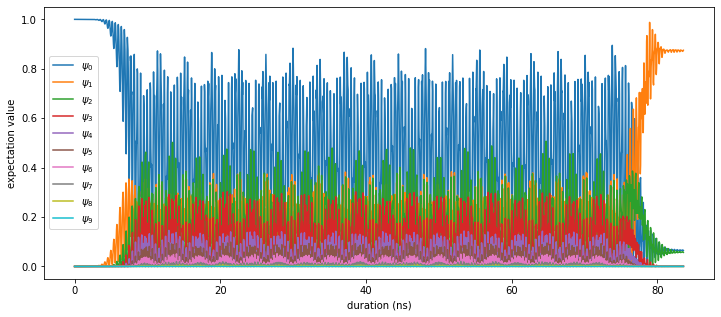

In [6]:
# Graph applied pulse

tanh.setup(amplitude, freq, ramp_slope, cut_factor, durations)

s = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, durations, system.starting_state, pbar=True)

graph.graph_solution(s, system)
print("fidelity", expv.expectation_value(s.final_state, system.target_state))

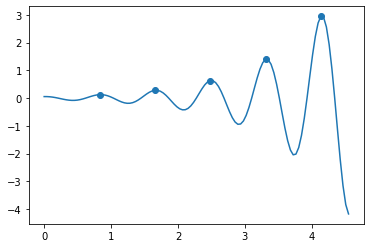

In [7]:
# Create list of points at peaks of pulse

dur_points = np.arange(0, t_max, (2*np.pi)/(freq))[::1]
dur_points = dur_points[1:-1]
pulse = tanh.get_pulse(durations)
num_of_points = 111
num_of_durPoints = 5

plt.plot(durations[:num_of_points], pulse[:num_of_points])
plt.scatter(dur_points[:num_of_durPoints], tanh.get_pulse(dur_points)[:num_of_durPoints])


In [8]:
# utility functions 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print("error, duration does not exactly exist!", value, array[idx])
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

# generate floquet kets
kets = []
for dur in dur_points:
    dur_amp = tanh.pulse_func(dur)
    def steady(t, args=None):
        return dur_amp * np.cos(freq * t)
    H = [system.H0, [system.H1, steady]]

    floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
    kets.append(floquet_kets)

# sort floquet kets
sorted_kets = [np.array(kets[0]).reshape((10,10))]
for i in range(1, len(dur_points)):
    reshaped_ket = np.array(kets[i]).reshape((10,10))
    m = np.abs(np.dot( (sorted_kets[-1]), np.transpose(reshaped_ket)  ))**2
    row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)
    # print(col_ind)
    sorted_kets.append( reshaped_ket[col_ind] )

# correctly order sorted kets
expv_for_sorted_unordered_kets = []
dur = dur_points[0]
index_of_dur = find_nearest(durations, dur)
for k in sorted_kets[0]:
    expv_for_sorted_unordered_kets.append(qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k)))
for t in range(0, len(sorted_kets)):
    temp = []
    for i in list(np.flip(np.argsort(expv_for_sorted_unordered_kets))):
        temp.append(sorted_kets[t][i])
    sorted_kets[t] = temp
# sorted_kets = np.array(sorted_kets)[list(np.flip(np.argsort(expv_for_sorted_unordered_kets)))]


# find overlaps of sorted kets
overlaps = []
expectation_values = []
for i in range(len(dur_points)):
    ket = sorted_kets[i]
    dur = dur_points[i]
    index_of_dur = find_nearest(durations, dur)
    overlaps_at_this_dur = []
    expv_at_this_dur = []
    for k in ket:
        expv_at_this_dur.append(qutip.expect(qutip.ket2dm(s.states[index_of_dur]), qutip.Qobj(k)))
        overlaps_at_this_dur.append(overlap(s.states[index_of_dur], qutip.Qobj(k)))
    overlaps.append(np.array(overlaps_at_this_dur))
    expectation_values.append(np.array(expv_at_this_dur))

overlaps = np.transpose(np.array(overlaps))
expectation_values = np.transpose(np.array(expectation_values))

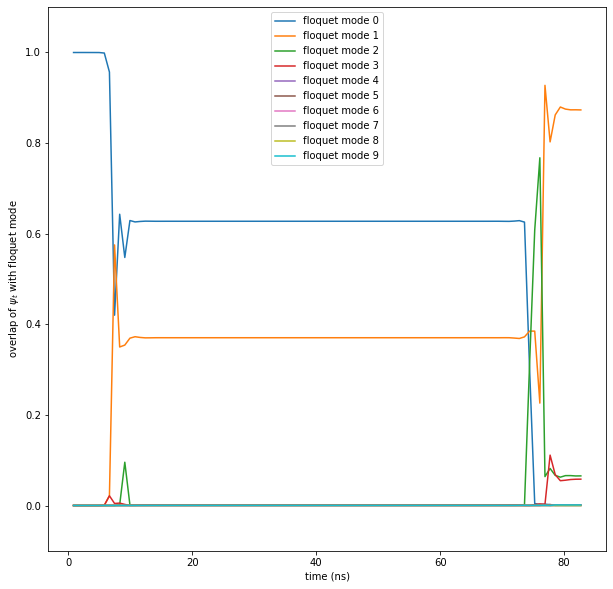

In [10]:
plt.figure(figsize=(10,10))
for i in range(0, len(expectation_values)):
    o = expectation_values[i]
    plt.plot(dur_points, o, label=r'floquet mode %i' % i)
# plt.plot(dur_points, overlaps, label=labeled_overlaps)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.show()

In [11]:
# Generate Bloch Sphere Rotation

# xs = []
# ys = []
# zs = []
# overlaps = np.transpose(overlaps)
# for i in range(0, len(overlaps)):
#     c0 = overlaps[i,3]
#     c1 = overlaps[i,4]
#     xs.append( np.conjugate(c0) * c1 + c0 * np.conjugate(c1) )
#     ys.append( -1j * np.conjugate(c0) * c1 + 1j * c0 * np.conjugate(c1) )
#     zs.append( np.conjugate(c0) * c0 - c1 * np.conjugate(c1) )

#     # xs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmax()))
#     # ys.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmay()))
#     # zs.append(qutip.expect(qutip.ket2dm(ket), qutip.sigmaz()))
#     # vecs.append([xs[-1], ys[-1], zs[-1]])


# from matplotlib import pyplot, animation
# from mpl_toolkits.mplot3d import Axes3D

# fig = pyplot.figure()
# ax = Axes3D(fig, azim=-40, elev=30)
# sphere = qutip.Bloch(axes=ax)

# def animate(i):
#     sphere.clear()
#     sphere.add_points([xs[i:i+1], ys[i:i+1], zs[i:i+1]])
#     sphere.make_sphere()
#     return ax

# def init():
#     sphere.vector_color = ['r']
#     return ax

# ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
#                             init_func=init, blit=False, repeat=False)

# ani.save('%s_bloch_sphere.mp4' % "tanh_%f" % amp, fps=20)

IndexError: list index out of range

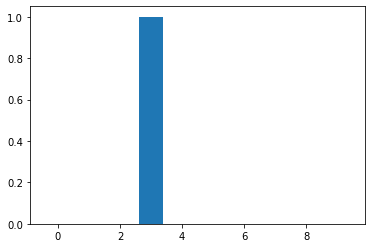

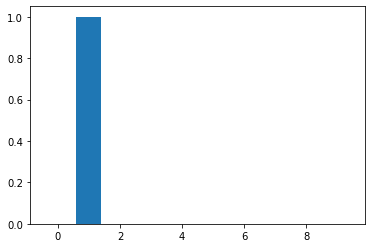

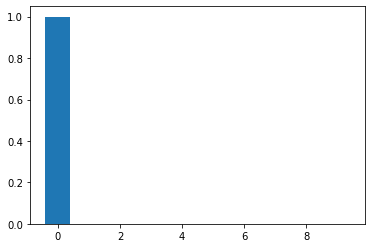

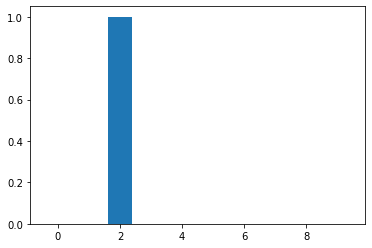

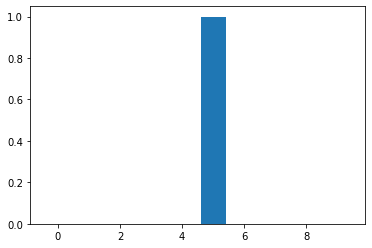

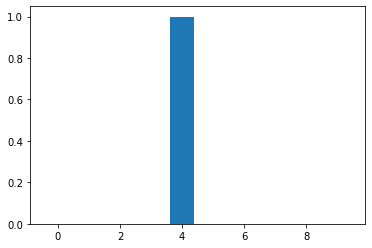

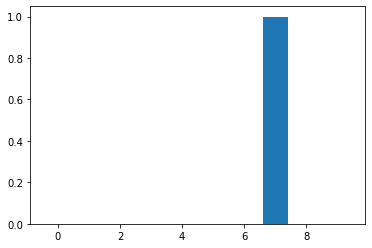

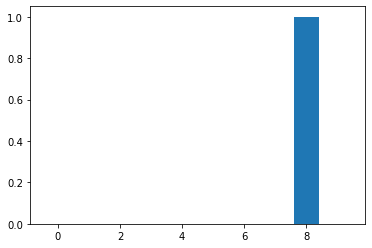

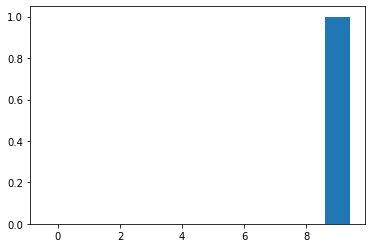

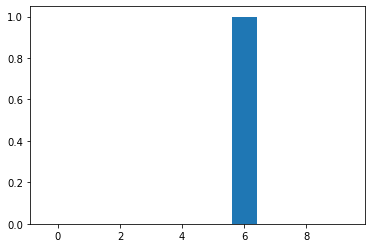

<Figure size 432x288 with 0 Axes>

In [13]:
# Look at how much floquet states occupy fock states during flat top driving

def getFockStateOccupancy(ket):
    overlaps = []
    for fock_ket in system.basis_states:
        overlaps.append(expv.expectation_value(qutip.Qobj(ket.reshape(1,10)), fock_ket))
    return overlaps

for floquet_mode_of_interest in range(0, len(sorted_kets)):
    fig=plt.figure()
    n=len(dur_points) #Number of frames
    barcollection = plt.bar(range(len(system.basis_states)),getFockStateOccupancy(sorted_kets[0][floquet_mode_of_interest]))

    def animate(i):
        y=getFockStateOccupancy(sorted_kets[i][floquet_mode_of_interest])
        for i, b in enumerate(barcollection):
            b.set_height(y[i])

    anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                                interval=100)

    anim.save('floquet_mode_%i_@_amplitude=%f.mp4' % (floquet_mode_of_interest, amplitude),writer=animation.FFMpegWriter(fps=10))